# Grab the vertices of the glacier terminus boxes in pixel coordinates

### Jukes Liu

The vertices of the glacier terminus box will be used to calculate a midpoint of the left edge of the terminus box, which will be our reference point for calculating terminus position.

### Import packages, set basepath, grab BoxIDs for terminus boxes

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

basepath = '/home/jukes/Documents/Sample_glaciers/'

In [30]:
def midpoint(x1, y1, x2, y2):
    midx = (x1+x2)/2
    midy = (y1+y2)/2
    return midx, midy

In [23]:
#grab the BoxIDs
pathrows_df = pd.read_csv(basepath+'LS_pathrows_SE.csv', sep=',', usecols =[0,1,2], dtype=str)
pathrows_df = pathrows_df.set_index('BoxID')
pathrows_df = pathrows_df.drop('215')
pathrows_df
BoxIDs = pathrows_df.index
# BoxIDs = ['219', '279']

### Read in terminus box rasters and perform a visual check

In [24]:
#create dictionary to store each terminus box ndarray by BoxID
termboxes = {}

#read in the terminus box rasters
for BoxID in BoxIDs:
    #load in the raster
#     boxpath = basepath+"Box"+BoxID+"/rotated_images/final/crop_Box"+BoxID+"_raster_cut.pgm"
    boxpath = "/media/jukes/jukes1/LS8aws/Box"+BoxID+"/resized/crop_R_Box"+BoxID+"_cut.pgm"
    #read the raster into an ndarray
    termbox = mpimg.imread(boxpath)
    #add the ndarray into a dictionary with the BoxID as the key
    termboxes.update( {BoxID: termbox} )

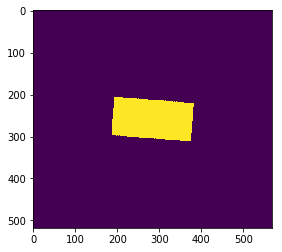

In [25]:
#visualize each terminus box rasters by BoxID
termplot = plt.imshow(termboxes['214'])
plt.show()

### Find x,y coordinates of box vertices and midpoints of left and right edges to get the centerline

    1) Left side
        1A) Top Left (lowest x*y)
        1B) Bottom Left (highest y/x)
        1C) Midpoint of 1A and 1B:
$\dfrac{x_{1}+x_{2}}{2}$ , $\dfrac{y_{1}+y_{2}}{2}$

    2) Right side
        2A) Top Right (highest y/x)
        2B) Bottom Right (highest x*y)
        2C) Midpoint of 2A and 2B.
        
    3) Centerline equation

Calculate the equation for the centerline (slope between the two midpoints). Just need to calculate slope: $m =\dfrac{y_{2}-y_{1}}{x_{2}-x_{1}}$

and solve for the intercept using one of the midpoint coordinate pairs: $b = y - mx$

$y = mx + b$

In [48]:
#create dictionary to store the all coordinates of the box rasters
boxes_xcoords = {}
boxes_ycoords = {}

#create dictionaries for the box vertices
topleft_coords = {}
bottomleft_coords = {}
topright_coords = {}
bottomright_coords = {}

#create lists to store the left midpoints (1C) and right midpoints (2C)
midpoints_x = []
midpoints_y = []

midpoints_r_x = []
midpoints_r_y = []

mids_l025_x = []
mids_l025_y = []

mids_r025_x = []
mids_r025_y = []

mids_l075_x = []
mids_l075_y = []

mids_r075_x = []
mids_r075_y = []

#create lists to store the slopes and intercepts of the centerline equations
slope_50 = []
intercept_50 = []
slope_25 = []
intercept_25 = []
slope_75 = []
intercept_75 = []
boxes = []

#for all the box rasters
for BoxID in BoxIDs:
    #Read in the raster of the BoxID of interest
    BOI = termboxes[BoxID]
    
    #find the coordinates of where the pixel value is nonzero (where the box exists)
    yindices, xindices = np.where(BOI > 0)

    #add box coordinates to the dictionary
    boxes_ycoords.update( {BoxID: yindices})
    boxes_xcoords.update( {BoxID: xindices})
    
    
    #1A) FIND THE TOP LEFT COORDINATES (lowest x*y)
    xy = xindices*yindices
    #Find the lowest xy value
    min_xy = np.min(xy)
    #Find the x and y pair corresponding to that xy using the index
    min_xy_i = np.where(xy == min_xy)[0][0]
    topleft = [xindices[min_xy_i], yindices[min_xy_i]]
#     print("Top left", topleft)
    #Add to dictionary of topleft coordinates
    topleft_coords.update(  {BoxID: topleft}  )
    
    #2B) FIND THE BOTTOM RIGHT COORDINATES (highest x*y)
    max_xy = np.max(xy)
    max_xy_i = np.where(xy == max_xy)[0][0]
    bottomright = [xindices[max_xy_i], yindices[max_xy_i]]
    bottomright_coords.update( {BoxID: bottomright})

    #1B) FIND THE BOTTOM LEFT COORDINATE(highest y/x)
    y_x = yindices/xindices
    #Find the highest y/x value
    max_y_x = np.max(y_x)
    #Find the x and y pair corresponding to that y/x using the index
    max_y_x_i = np.where(y_x == max_y_x)[0][0]
    bottomleft = [xindices[max_y_x_i], yindices[max_y_x_i]]
#     print("Bottom left", bottomleft)
    #Add to dictionary of bottomleft coordinates
    bottomleft_coords.update( {BoxID: bottomleft}  )
    
    #2A) FIND THE TOP RIGHT COORDINATES (highest x/y)
    x_y = xindices/yindices
    #find highest x/y value:
    max_x_y = np.max(x_y)
    #Find the x, y pair correpsonding to the maximum x/y using the index
    max_x_y_i = np.where(x_y == max_x_y)[0][0]
    topright = [xindices[max_x_y_i], yindices[max_x_y_i]]
    topright_coords.update( {BoxID: topright} )
    
    #1C and 2C) CALCULATE THE MIDPOINTS USING MIDPOINT FUNCTION
    #Left
    midpoint_x, midpoint_y = midpoint(topleft[0], topleft[1], bottomleft[0], bottomleft[1])
    #Right
    midpoint_r_x, midpoint_r_y = midpoint(topright[0], topright[1], bottomright[0], bottomright[1])
    
#     #Add x and y coordinates to dictionaries
#     midpoints_x.update( {BoxID: midpoint_x}  )
#     midpoints_y.update( {BoxID: midpoint_y}  )
#     midpoints_r_x.update( {BoxID: midpoint_r_x})
#     midpoints_r_y.update( {BoxID: midpoint_r_y})
    
    #GRAB 1/4th and 3/4ths lines (midpoints)
    mid_l025_x, mid_l025_y = midpoint(topleft[0], topleft[1], midpoint_x, midpoint_y)
    mid_r025_x, mid_r025_y = midpoint(topright[0], topright[1], midpoint_r_x, midpoint_r_y)
    
    mid_l075_x, mid_l075_y = midpoint(bottomleft[0], bottomleft[1], midpoint_x, midpoint_y)
    mid_r075_x, mid_r075_y = midpoint(bottomright[0], bottomright[1], midpoint_r_x, midpoint_r_y)
    
    #3) CALCULATE CENTERLINE EQUATIONS
    #1/2
    #slope = (y2-y1)/(x2-x1)
    m = (midpoint_r_y - midpoint_y)/(midpoint_r_x - midpoint_x)
    #y-intercept = y1 - m*x1
    b = midpoint_y - (m*midpoint_x)
#     print("y =", m, "x +", b)

    #1/4
    m025 = (mid_r025_y-mid_l025_y)/(mid_r025_x-mid_l025_x)
    b025 = mid_l025_y - (m*mid_l025_x)
    
    #3/4
    m075 = (mid_r075_y-mid_l075_y)/(mid_r075_x-mid_l075_x)
    b075 = mid_l075_y - (m*mid_l075_x)
    
    #append BoxIDs, slopes, intercepts, midpoints, and centerlines to lists
    boxes.append(BoxID)
    midpoints_x.append(midpoint_x)
    midpoints_y.append(midpoint_y)
    midpoints_r_x.append(midpoint_r_x)
    midpoints_r_y.append(midpoint_r_y)
    
    mids_l025_x.append(mid_l025_x)
    mids_l025_y.append(mid_l025_y)
    mids_r025_x.append(mid_r025_x)
    mids_r025_y.append(mid_r025_y)
    
    mids_l075_x.append(mid_l075_x)
    mids_l075_y.append(mid_l075_y)
    mids_r075_x.append(mid_r075_x)
    mids_r075_y.append(mid_r075_y)
    
    slope_50.append(m)
    intercept_50.append(b)
    slope_25.append(m025)
    intercept_25.append(b025)
    slope_75.append(m075)
    intercept_75.append(b075)
    
#create a dataframe
total_df = pd.DataFrame(list(zip(boxes, midpoints_x, midpoints_y, midpoints_r_x, midpoints_r_y, slope_50, 
                                 intercept_50, mids_l025_x, mids_l025_y, mids_r025_x, mids_r025_y, slope_25, 
                                 intercept_25, mids_l075_x, mids_l075_y, mids_r075_x, mids_r075_y, slope_75, 
                                intercept_75)), 
                        columns=['BoxID', 'lmid50_x', 'lmid50_y', 'rmid50_x','rmid50_y', 'm50', 'b50',
                                 'lmid25_x', 'lmid25_y','rmid25_x','rmid25_y', 'm25', 'b25',
                                 'lmid75_x', 'lmid75_y', 'rmid75_x','rmid75_y', 'm75', 'b75'])

total_df = total_df.drop_duplicates().set_index('BoxID')
total_df

,lmid50_x,lmid50_y,rmid50_x,rmid50_y,m50,b50,lmid25_x,lmid25_y,rmid25_x,rmid25_y,m25,b25,lmid75_x,lmid75_y,rmid75_x,rmid75_y,m75,b75
BoxID,,,,,,,,,,,,,,,,,,
147,63.0,91.5,128.0,123.5,0.492308,60.484615,68.00,81.25,132.50,113.75,0.503876,47.773077,58.00,101.75,123.50,133.25,0.480916,73.196154
148,68.5,94.0,104.0,85.0,-0.253521,111.366197,65.25,80.00,100.50,71.00,-0.255319,96.542254,71.75,108.00,107.50,99.00,-0.251748,126.190141
149,40.5,71.5,84.5,64.0,-0.170455,78.403409,39.75,66.25,83.75,59.00,-0.164773,73.025568,41.25,76.75,85.25,69.00,-0.176136,83.781250
150,40.0,68.5,85.5,72.5,0.087912,64.983516,40.50,62.75,86.25,66.25,0.076503,59.189560,39.50,74.25,84.75,78.75,0.099448,70.777473
152,63.5,87.0,123.0,107.5,0.344538,65.121849,67.75,76.00,126.50,96.75,0.353191,52.657563,59.25,98.00,119.50,118.25,0.336100,77.586134
190,142.5,219.5,272.5,195.5,-0.184615,245.807692,137.75,194.75,267.75,170.75,-0.184615,220.180769,147.25,244.25,277.25,220.25,-0.184615,271.434615
191,116.5,180.5,230.5,178.0,-0.021930,183.054825,116.25,159.75,229.75,157.00,-0.024229,162.299342,116.75,201.25,231.25,199.00,-0.019651,203.810307
192,47.5,58.5,85.5,78.0,0.513158,34.125000,50.75,52.25,88.25,72.00,0.526667,26.207237,44.25,64.75,82.75,84.00,0.500000,42.042763
193,71.0,155.0,172.0,128.5,-0.262376,173.628713,70.50,153.00,167.00,117.75,-0.365285,171.497525,71.50,157.00,177.00,139.25,-0.168246,175.759901


### Visual check of the vertices, midpoints, and centerlines by plotting over terminus box:

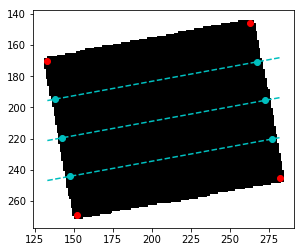

In [53]:
#Choose which glacier BoxID to check:
BOI_ID = '190'

#plot the raster pixels in black
plt.scatter(boxes_xcoords[BOI_ID], boxes_ycoords[BOI_ID], c='k',marker='s')

#plot the vertices in red
plt.scatter(topleft_coords[BOI_ID][0], topleft_coords[BOI_ID][1], c='r')
plt.scatter(bottomleft_coords[BOI_ID][0], bottomleft_coords[BOI_ID][1], c='r')
plt.scatter(topright_coords[BOI_ID][0], topright_coords[BOI_ID][1], c='r')
plt.scatter(bottomright_coords[BOI_ID][0], bottomright_coords[BOI_ID][1], c='r')

#plot midpoints in cyan
plt.scatter(total_df.at[BOI_ID,'lmid50_x'], total_df.at[BOI_ID,'lmid50_y'], c='c')
plt.scatter(total_df.at[BOI_ID, 'rmid50_x'], total_df.at[BOI_ID, 'rmid50_y'], c='c')
plt.scatter(total_df.at[BOI_ID,'lmid25_x'], total_df.at[BOI_ID,'lmid25_y'], c='c')
plt.scatter(total_df.at[BOI_ID, 'rmid25_x'], total_df.at[BOI_ID, 'rmid25_y'], c='c')
plt.scatter(total_df.at[BOI_ID,'lmid75_x'], total_df.at[BOI_ID,'lmid75_y'], c='c')
plt.scatter(total_df.at[BOI_ID, 'rmid75_x'], total_df.at[BOI_ID, 'rmid75_y'], c='c')

#plot the centerlines in cyan
x=np.linspace(np.min(boxes_xcoords[BOI_ID]), np.max(boxes_xcoords[BOI_ID]))
y50=(total_df.at[BOI_ID, 'm50'])*x + (total_df.at[BOI_ID, 'b50'])
y25=(total_df.at[BOI_ID, 'm25'])*x + (total_df.at[BOI_ID, 'b25'])
y75=(total_df.at[BOI_ID, 'm75'])*x + (total_df.at[BOI_ID, 'b75'])
plt.plot(x, y50, '--c', x, y25, '--c', x, y75, '--c')
         
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.show()

### Drop right midpoint columns and dataframe to csv

In [58]:
total_df = total_df.drop(['rmid50_x', 'rmid50_y', 'rmid25_x', 'rmid25_y', 'rmid75_x', 'rmid75_y'], axis=1)
total_df.head()

#### Export to Boxes_coords_pathrows.csv

In [59]:
total_df.to_csv(path_or_buf = basepath+'Boxes_coords_pathrows_SE.csv', sep=',')